In [20]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [22]:
#  Aggregate transaction data for each customer
customer_transactions = transactions_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count'
}).rename(columns={
    'TotalValue': 'TotalSpent',
    'Quantity': 'TotalQuantity',
    'TransactionID': 'TransactionCount'
})

In [23]:
#  Merge with customer profile information
merged_customers = pd.merge(customers_df, customer_transactions, on='CustomerID', how='left').fillna(0)

In [24]:
#  Encode categorical variables (Region)
encoded_data = pd.get_dummies(merged_customers[['Region']], drop_first=True)

In [25]:
#  Combine numerical and encoded features
numerical_data = merged_customers[['TotalSpent', 'TotalQuantity', 'TransactionCount']]
final_features = pd.concat([numerical_data, encoded_data], axis=1)

In [26]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_features)

In [27]:
#  Determine the optimal number of clusters using DB Index
k_values = range(2, 11)
db_scores = []


In [28]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    db_scores.append(davies_bouldin_score(scaled_features, kmeans.labels_))




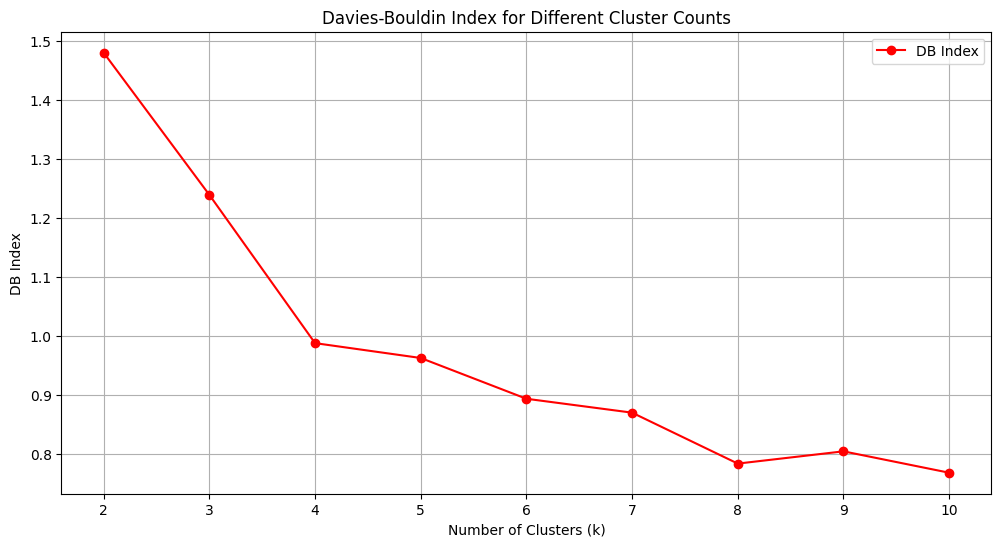

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, db_scores, marker='o', label='DB Index', color='red')
plt.title('Davies-Bouldin Index for Different Cluster Counts')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DB Index')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
#  Perform clustering with optimal k
optimal_k = k_values[db_scores.index(min(db_scores))]
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_optimal.fit_predict(scaled_features)

In [31]:
merged_customers['Cluster'] = clusters

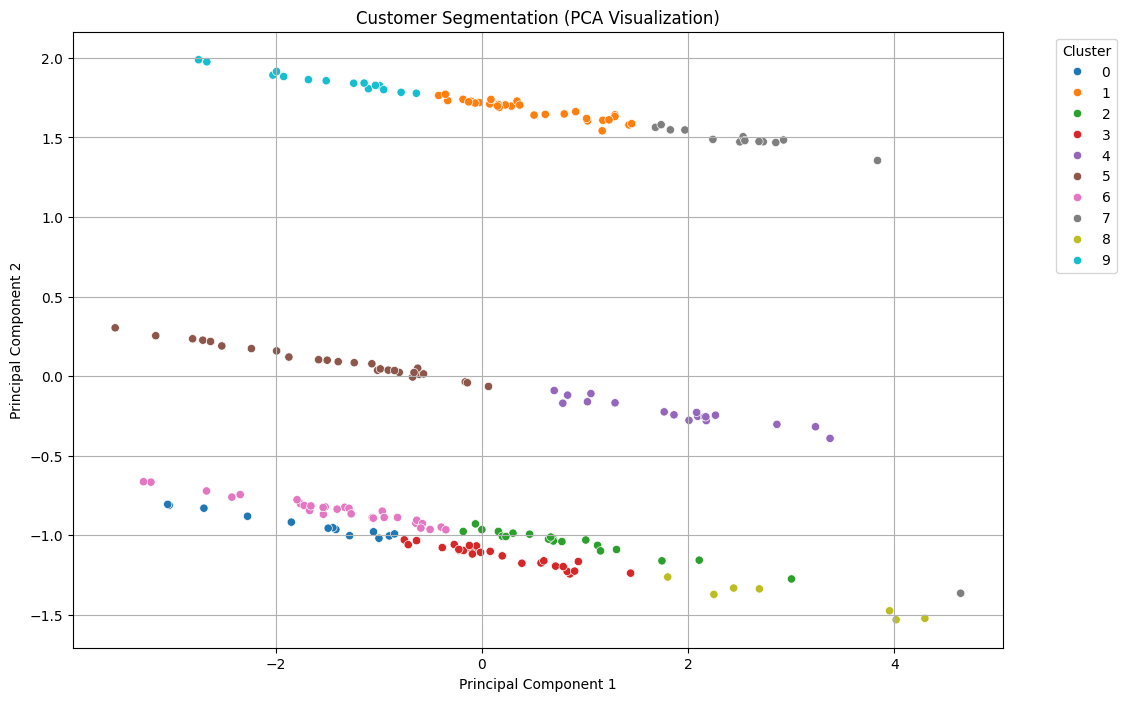

In [32]:
# Visualize clusters using PCA
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(scaled_features)
merged_customers['PCA1'] = reduced_data[:, 0]
merged_customers['PCA2'] = reduced_data[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='tab10',
    data=merged_customers,
    legend='full'
)
plt.title('Customer Segmentation (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [33]:
merged_customers.to_csv('Rosemary_Jose_Customer_Clustering.csv', index=False)

In [38]:
# Print each DB score corresponding to the number of clusters
print("Davies-Bouldin Index for Different Cluster Counts:")
for k, db_score in zip(k_values, db_scores):
    print(f"Number of Clusters: {k}, DB Index: {db_score:.4f}")

# Print the optimal number of clusters and the minimum DB Index
optimal_k = k_values[db_scores.index(min(db_scores))]
print(f"\nOptimal Number of Clusters: {optimal_k}")
print(f"Minimum Davies-Bouldin Index: {min(db_scores):.4f}")



Davies-Bouldin Index for Different Cluster Counts:
Number of Clusters: 2, DB Index: 1.4795
Number of Clusters: 3, DB Index: 1.2388
Number of Clusters: 4, DB Index: 0.9877
Number of Clusters: 5, DB Index: 0.9625
Number of Clusters: 6, DB Index: 0.8935
Number of Clusters: 7, DB Index: 0.8700
Number of Clusters: 8, DB Index: 0.7837
Number of Clusters: 9, DB Index: 0.8045
Number of Clusters: 10, DB Index: 0.7682

Optimal Number of Clusters: 10
Minimum Davies-Bouldin Index: 0.7682
